# GP Practices with large volume of GP2GP transfers and failures

Hypothesis:
- We believe that GPs who are impacted with large volumes of GP2GP transfers and failures will be feeling pain, and will be more likely to participate in user research

Questions:
- Which practices have large volumes of GP2GP transfers?
  - Which practices have large volumes of GP2GP transfers as a sending practice?
  - Which practices have large volumes of GP2GP transfers as a receiving practice? 
- Which practices have large volumes of GP2GP transfer failures?
- Which practices have large volumes of GP2GP transfer success?

Other considerations:
- GP2GP utilisation may change month-over-month; thus look at patterns over time, not just for a single time period

## Requesting practices

We'll export data from NMS using the following Splunk query:

```splunk
index="gp2gp-mi" sourcetype="gppractice-RR"
| eval key=RegistrationTime + "-" + RegistrationSmartcardUID
| eval Outcome=coalesce(ExtractAckStatus, "No") + "-" + coalesce(ExtractAckCode, "EAM")
| eval Month=substr(RegistrationTime, 6, 2)
| stats values(RequestorODS) as RequestorODS,
        max(eval(isnotnull(ConversationID))) as GP2GPRequest,
        dc(eval(Outcome="1-00" or Outcome="1-0")) as Integrated,
        dc(eval(Outcome="5-15")) as Suppressed,
        BY key, Month
| stats dc(key) as RegistrationCount,
        sum(GP2GPRequest) as RequestCount,
        sum(Integrated) as IntegratedCount,
        sum(Suppressed) as SuppressedCount
        BY RequestorODS, Month
| eval SuccessRate=(IntegratedCount + SuppressedCount)/RequestCount
```


Exported the above as `data/PRMT-365-Requestor-transfer.csv` for further analysis (below).

In [1]:
import paths
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import data

In [3]:
%matplotlib inline

In [4]:
requestor_view = pd.read_csv(data.PRMT_365_Requestor_transfers.path)
requestor_view["SuccessCount"] = requestor_view["IntegratedCount"] + requestor_view["SuppressedCount"]
requestor_view["Month"] = requestor_view["Month"].map({5:"May", 6:"June", 7:"July", 8:"August"})
requestor_view = requestor_view.set_index(["RequestorODS", "Month"])

months = ["May","June","July","August"]
ODSs = list(set(requestor_view.index.get_level_values("RequestorODS")))
CompleteIndex = pd.MultiIndex.from_product([ODSs, months], names=["RequestorODS", "Month"])
requestor_view = requestor_view.reindex(CompleteIndex)

In [5]:
ods_lookup = pd.read_csv(
    data.GP_ODS_Data.path,
    names=data.GP_ODS_Data.columns,
    index_col="ODSCode",
    usecols=["ODSCode","Name","NationalGrouping","HighLevelHealthGeography","Postcode",
             "PrescribingSetting","ContactTelephoneNumber"]
)

In [6]:
requestor_view_aggregated_over_time = requestor_view.groupby(by="RequestorODS").sum()[
    ["RegistrationCount","RequestCount", "SuccessCount", "SuppressedCount"]
]
requestor_view_aggregated_over_time["SuccessRate"] = (requestor_view_aggregated_over_time["SuccessCount"]
                                                      /requestor_view_aggregated_over_time["RequestCount"])

A histogram of `RequestCount` aggregated over all 4 months (below) shows that:
- The vast majority of practices made fewer than 200 requests over the 4 month period
- Note that there were a few practices that made substantially more GP2GP requests (>1000; in one case, >7000) over the 4 months - these are not visible on the graph.

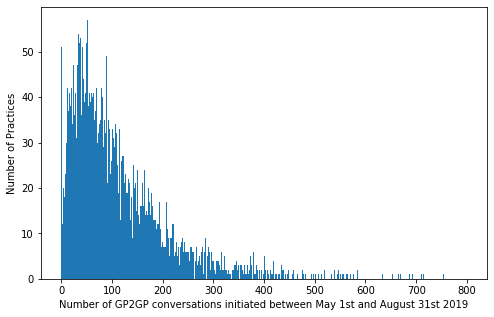

In [7]:
plt.figure(figsize=(8,5))
plt.hist(requestor_view_aggregated_over_time["RequestCount"], bins=np.linspace(0,800,800));
plt.xlabel("Number of GP2GP conversations initiated between May 1st and August 31st 2019");
plt.ylabel("Number of Practices");

A histogram of `SuccessRate` aggregated over all 4 months (below) shows that:

- A large majority of practices have a success rate of between 90% and 100%, with very few practices in the range 0% < SuccessRate < 90%.
- There remains a sizeable number of practices with quite low success rate

/Users/dmortime/dev/NHS/prm-gp2gp-data-sandbox/venv/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/dmortime/dev/NHS/prm-gp2gp-data-sandbox/venv/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


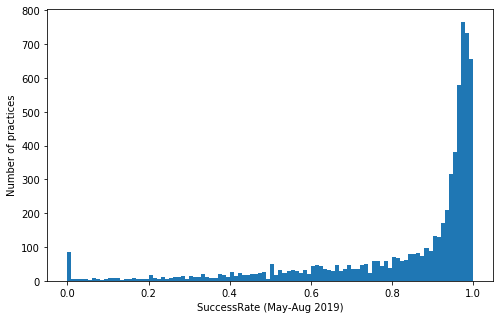

In [8]:
plt.figure(figsize=(8,5))
plt.hist(list(requestor_view_aggregated_over_time.sort_values(by="SuccessRate", ascending=True)["SuccessRate"]),
         bins=100);
plt.xlabel("SuccessRate (May-Aug 2019)");
plt.ylabel("Number of practices");

### Practices making a high volume of GP2GP requests

The practices that made more than 800 requests in the period from May to August 2019 were:

In [9]:
high_volume_practices = requestor_view_aggregated_over_time[requestor_view_aggregated_over_time["RequestCount"] > 800].sort_values(by="RequestCount", ascending=False)
high_volume_practices.iloc[:10]

,RegistrationCount,RequestCount,SuccessCount,SuppressedCount,SuccessRate
RequestorODS,,,,,
E85124,14936.0,7587.0,6829.0,0.0,0.900092
G85034,5486.0,3911.0,3843.0,387.0,0.982613
L81078,3397.0,3089.0,3062.0,62.0,0.991259
F84003,2553.0,2208.0,2170.0,122.0,0.982790
P91629,2388.0,2179.0,2115.0,166.0,0.970629
P91020,2216.0,2038.0,2013.0,142.0,0.987733
F84724,2303.0,1882.0,1870.0,69.0,0.993624
H81122,1879.0,1769.0,1759.0,62.0,0.994347
K81041,1711.0,1600.0,1591.0,32.0,0.994375


## Sending practices

We'll still use the `gppractice-RR` source for now, as we are interested in the ultimate outcome of the interaction, and this is only reported in this view. We can still identify the sending practice ODS.

There are a small number of conversations where the Requestor initiates a conversation with itself (i.e. it identifies itself as the Sender). I believe this occurs when a registration incorrectly triggers multiple GP2GP conversations, with one occurring after PDS has been updated for the patient to indicate that the Requestor is their primary care provider. These don't seem to have any impact in practice (they lead to a well-defined error code), so we'll just filter them out with `RequestorODS != SenderODS`.

```sql
index="gp2gp-mi" sourcetype="gppractice-RR"
| where isnotnull(ConversationID) and RequestorODS != SenderODS
| eval key=RegistrationTime + "-" + RegistrationSmartcardUID
| eval Outcome=coalesce(ExtractAckStatus, "No") + "-" + coalesce(ExtractAckCode, "EAM")
| eval Month=substr(RegistrationTime, 6, 2)
| stats values(RequestorODS) as RequestorODS,
        values(SenderODS) as SenderODS,
        dc(eval(Outcome="1-00" or Outcome="1-0")) as Integrated,
        dc(eval(Outcome="5-15")) as Suppressed,
        BY key, Month
| stats dc(key) as RequestCount,
        sum(Integrated) as IntegratedCount,
        sum(Suppressed) as SuppressedCount
        BY SenderODS, Month
| eval SuccessRate=(IntegratedCount + SuppressedCount)/RequestCount
```

In [10]:
sender_view = pd.read_csv(data.PRMT_365_Sender_transfers.path)
sender_view["Month"] = sender_view["Month"].map({5:"May", 6:"June", 7:"July", 8:"August"})
sender_view["SuccessCount"] = sender_view["IntegratedCount"] + sender_view["SuppressedCount"]
sender_view = sender_view.set_index(["SenderODS", "Month"])

months = ["May","June","July","August"]
ODSs = list(set(sender_view.index.get_level_values("SenderODS")))
CompleteIndex = pd.MultiIndex.from_product([ODSs, months], names=["SenderODS", "Month"])
sender_view = sender_view.reindex(CompleteIndex)

In [11]:
sender_view_aggregated_over_time = sender_view.groupby(by="SenderODS").sum()[["RequestCount", "SuccessCount", "SuppressedCount"]]
sender_view_aggregated_over_time["SuccessRate"] = (sender_view_aggregated_over_time["SuccessCount"]
                                                      /sender_view_aggregated_over_time["RequestCount"])

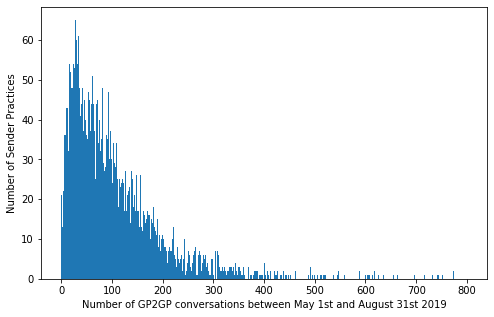

In [12]:
plt.figure(figsize=(8,5))
plt.hist(sender_view_aggregated_over_time["RequestCount"], bins=np.linspace(0,800,800));
plt.xlabel("Number of GP2GP conversations between May 1st and August 31st 2019");
plt.ylabel("Number of Sender Practices");

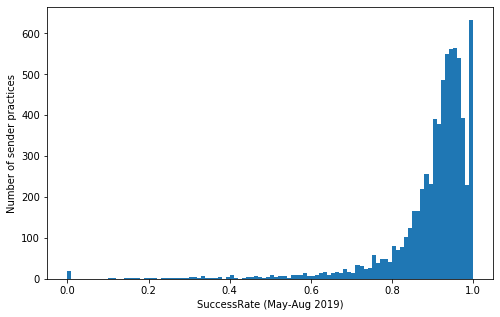

In [13]:
plt.figure(figsize=(8,5))
plt.hist(list(sender_view_aggregated_over_time.sort_values(by="SuccessRate", ascending=True)["SuccessRate"]),
         bins=100);
plt.xlabel("SuccessRate (May-Aug 2019)");
plt.ylabel("Number of sender practices");

### Practices involved as Senders in a large number of GP2GP conversations

The practices that responded to more than 800 requests in the period from May to August 2019 were:

In [14]:
high_volume_senders = sender_view_aggregated_over_time[sender_view_aggregated_over_time["RequestCount"] > 800].sort_values(by="RequestCount", ascending=False)
high_volume_senders.iloc[:10]

,RequestCount,SuccessCount,SuppressedCount,SuccessRate
SenderODS,,,,
L81112,4762.0,4683.0,133.0,0.983410
P91615,4410.0,4339.0,268.0,0.983900
F84631,3536.0,3495.0,60.0,0.988405
G85050,2931.0,2878.0,300.0,0.981917
H81079,2885.0,2809.0,78.0,0.973657
F84043,2640.0,2583.0,43.0,0.978409
B86110,2584.0,2219.0,691.0,0.858746
K81647,2511.0,2501.0,39.0,0.996018
E85124,2328.0,2222.0,428.0,0.954467


## Looking at individual practices

In [15]:
def view_trends_for_ods(ods):
    requestor_data = requestor_view.loc[ods]
    sender_data = sender_view.loc[ods]
    months = ["May", "June", "July", "August"]
    
    print(ods_lookup.loc[ods])
    
    figure = plt.figure(figsize=(14, 8))

    plt.subplot(2, 2, 1)
    plt.plot(months, requestor_data[["RequestCount", "IntegratedCount", "SuccessCount"]])
    plt.ylim(0)
    plt.title(f"GP2GP requests, integrations, and suppressions ({ods} - Requestor)")

    plt.subplot(2, 2, 2)
    plt.plot(months, requestor_data["SuccessRate"])
    plt.ylim((0, 1.1))
    plt.title(f"Success rate ({ods} - Requestor)")
    
    plt.subplot(2, 2, 3)
    plt.plot(months, sender_data[["RequestCount", "IntegratedCount", "SuccessCount"]])
    plt.ylim(0)
    plt.title(f"GP2GP requests, integrations, and suppressions ({ods} - Sender)")

    plt.subplot(2, 2, 4)
    plt.plot(months, sender_data["SuccessRate"])
    plt.ylim((0, 1.1))
    plt.title(f"Success rate ({ods} - Sender)")

### High volume requestors

For ODS=E85124 ("GP At Hand" -- the largest volume of GP2GP transfer requests), we have:

In [ ]:
view_trends_for_ods("E85124")

Name                          GP AT HAND
NationalGrouping                     Y56
HighLevelHealthGeography             Q71
Postcode                         SW6 7SX
ContactTelephoneNumber      0330 8082217
PrescribingSetting                     4
Name: E85124, dtype: object


### High volume senders

In [ ]:
view_trends_for_ods("L81112")

# North-West London Practices

In [ ]:
nw_london_ods_codes = ods_lookup.loc[ods_lookup["Postcode"].str.contains('^NW', regex=True, na=False)].index

In [ ]:
nw_london_ods_codes

In [ ]:
nw_london_requesting_practices_view = requestor_view_aggregated_over_time.loc[requestor_view_aggregated_over_time.index.intersection(nw_london_ods_codes)]

In [ ]:
nw_london_requesting_practices_view.sort_values(by="RequestCount", ascending=False)